# 전력사용하여 예측  
###### python version=3.7.6, tensoflow version=1.13.1

# step1 (전력만, optim=Adam)

In [1]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf  #딥러닝에 유용
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#랜덤한 겂을 다른 컴퓨터에도 동일하게 얻을 수 있음.
tf.set_random_seed(777)  

C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4]][1:]
# july_=july.loc[:,[1,2,4]][1:]

In [3]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량']
jan_[['월','일','전력량']]=jan_[['월','일','전력량']].apply(pd.to_numeric)

In [4]:
jan_

,월,일,전력량
1,1,1,238.32
2,1,1,236.16
3,1,1,237.24
4,1,1,236.16
5,1,1,234.72
...,...,...,...
2876,1,30,340.20
2877,1,30,294.12
2878,1,30,263.88
2879,1,30,261.00


In [5]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [6]:
#하이퍼 파라미터 설정

#한개의 시퀀스길이(시계열데이터 입력갯수,몇개의 rnn을 연결할지 결정,input보다는 같거나 많아야함)
timesteps = seq_length = 3  
#variable개수
data_dim = 3  
#각셀의 출력크기(많을수록 특정 훈련데이터에 최적화 가능)
hidden_dim = 3  
#결과분류 총 수
output_dim = 1  
#학습률
learing_rate = 0.001  
#에폭횟수
iterations = 50_000  

In [7]:
# #데이터 조절
# jan_["전력량"] /= 1e5

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량']].values
y = jan_["전력량"].values  

In [8]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [11]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [12]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [13]:
# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

# sum of the squares= 표준편차(예측값과 실제값의차이) 평균제곱오차
loss = tf.reduce_sum(tf.square(Y_pred - Y))  

In [15]:
#RMSprop 알고리즘->adam
optimizer= tf.train.AdamOptimizer(learing_rate)
train = optimizer.minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 367.8433837890625
[step: 100] loss: 136.95797729492188
[step: 150] loss: 121.83451843261719
[step: 200] loss: 121.6681900024414
[step: 250] loss: 121.46723937988281
[step: 300] loss: 121.10665130615234
[step: 350] loss: 120.03763580322266
[step: 400] loss: 97.90396881103516
[step: 450] loss: 15.181621551513672
[step: 500] loss: 13.013257026672363
[step: 550] loss: 12.247529029846191
[step: 600] loss: 11.639495849609375
[step: 650] loss: 11.086577415466309
[step: 700] loss: 10.583253860473633
[step: 750] loss: 10.132729530334473
[step: 800] loss: 9.730953216552734
[step: 850] loss: 9.348456382751465
[step: 900] loss: 8.994729042053223
[step: 950] loss: 8.681501388549805
[step: 1000] loss: 8.390107154846191
[step: 1050] loss: 8.100534439086914
[step: 1100] loss: 7.794903755187988
[step: 1150] loss: 7.4552178382873535
[step: 1200] loss: 7.060174465179443
[step: 1250] loss: 6.506078243255615
[step: 1300] loss: 5.93638801574707
[step: 1350] loss: 5.304925441741943
[step: 14

[step: 10550] loss: 0.037981338798999786
[step: 10600] loss: 0.007259109988808632
[step: 10650] loss: 0.007038936018943787
[step: 10700] loss: 0.006999317556619644
[step: 10750] loss: 0.006959930062294006
[step: 10800] loss: 0.006920244544744492
[step: 10850] loss: 0.02353562042117119
[step: 10900] loss: 0.0069527216255664825
[step: 10950] loss: 0.006835595238953829
[step: 11000] loss: 0.006798255257308483
[step: 11050] loss: 0.006761427037417889
[step: 11100] loss: 0.006726279854774475
[step: 11150] loss: 0.01373252086341381
[step: 11200] loss: 0.006675929296761751
[step: 11250] loss: 0.006639034487307072
[step: 11300] loss: 0.00660386448726058
[step: 11350] loss: 0.00657700328156352
[step: 11400] loss: 0.011486773379147053
[step: 11450] loss: 0.006538475397974253
[step: 11500] loss: 0.006490206345915794
[step: 11550] loss: 0.0064567867666482925
[step: 11600] loss: 0.006423441227525473
[step: 11650] loss: 0.02287064865231514
[step: 11700] loss: 0.006420782767236233
[step: 11750] loss:

[step: 20550] loss: 0.00378809729591012
[step: 20600] loss: 0.003777463687583804
[step: 20650] loss: 0.003766907611861825
[step: 20700] loss: 0.0037563194055110216
[step: 20750] loss: 0.0037456396967172623
[step: 20800] loss: 0.003902699099853635
[step: 20850] loss: 0.0040644314140081406
[step: 20900] loss: 0.003726349910721183
[step: 20950] loss: 0.0037156546022742987
[step: 21000] loss: 0.003705037524923682
[step: 21050] loss: 0.07673534750938416
[step: 21100] loss: 0.0036989760119467974
[step: 21150] loss: 0.003687989665195346
[step: 21200] loss: 0.003675735555589199
[step: 21250] loss: 0.00366602442227304
[step: 21300] loss: 0.015479227527976036
[step: 21350] loss: 0.0036903286818414927
[step: 21400] loss: 0.0036472624633461237
[step: 21450] loss: 0.0036366041749715805
[step: 21500] loss: 0.004326165188103914
[step: 21550] loss: 0.00523380609229207
[step: 21600] loss: 0.0036257272586226463
[step: 21650] loss: 0.0036083466839045286
[step: 21700] loss: 0.0035981948021799326
[step: 21

[step: 30500] loss: 0.006043482571840286
[step: 30550] loss: 0.0038187927566468716
[step: 30600] loss: 0.002655531745404005
[step: 30650] loss: 0.0026479160878807306
[step: 30700] loss: 0.002641932340338826
[step: 30750] loss: 0.002649498637765646
[step: 30800] loss: 0.0040956041775643826
[step: 30850] loss: 0.0026591969653964043
[step: 30900] loss: 0.0026302561163902283
[step: 30950] loss: 0.0026242334861308336
[step: 31000] loss: 0.0026183833833783865
[step: 31050] loss: 0.0034867534413933754
[step: 31100] loss: 0.004311629571020603
[step: 31150] loss: 0.00262302253395319
[step: 31200] loss: 0.0026063371915370226
[step: 31250] loss: 0.0026005543768405914
[step: 31300] loss: 0.0025948036927729845
[step: 31350] loss: 0.053183671087026596
[step: 31400] loss: 0.00260361866094172
[step: 31450] loss: 0.0025904481299221516
[step: 31500] loss: 0.002582871587947011
[step: 31550] loss: 0.0025771812070161104
[step: 31600] loss: 0.0025797744747251272
[step: 31650] loss: 0.007348580751568079
[ste

[step: 40400] loss: 0.0020245579071342945
[step: 40450] loss: 0.0020202072337269783
[step: 40500] loss: 0.0025834739208221436
[step: 40550] loss: 0.0020845551043748856
[step: 40600] loss: 0.0020169883500784636
[step: 40650] loss: 0.00201222556643188
[step: 40700] loss: 0.002007913775742054
[step: 40750] loss: 0.0020038350485265255
[step: 40800] loss: 0.011317586526274681
[step: 40850] loss: 0.0020099999383091927
[step: 40900] loss: 0.002000769367441535
[step: 40950] loss: 0.001996035221964121
[step: 41000] loss: 0.0019918116740882397
[step: 41050] loss: 0.001998401479795575
[step: 41100] loss: 0.006299569271504879
[step: 41150] loss: 0.001987363211810589
[step: 41200] loss: 0.0019828900694847107
[step: 41250] loss: 0.001978654880076647
[step: 41300] loss: 0.001977133797481656
[step: 41350] loss: 0.009178830310702324
[step: 41400] loss: 0.0019795072730630636
[step: 41450] loss: 0.001969641540199518
[step: 41500] loss: 0.001965255243703723
[step: 41550] loss: 0.0020037649665027857
[step:

In [17]:
a=0
length=len(dataY)
for k in range(0,length-1):
    a+=dataY[k][0]
real_avg=a/length

test_predict = sess.run(Y_pred, feed_dict={X: testX}) #예측값
length_=len(test_predict)

b=0
for j in range(0,length_-1):
    b+=test_predict[j][0]
pred_avg=b/length_
    
#(절대값(실제값의 평균 - 예측값의 평균)/실제값의 평균) *100 =평균 오차율 산정 방식
accuracy=(abs(real_avg-pred_avg)/real_avg)*100
print(accuracy)

0.06598569191932


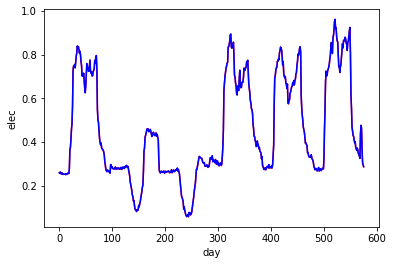

In [18]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})


plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()

# step2 (전력,온도, optim=Adam)

In [2]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf  #딥러닝에 유용
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#랜덤한 겂을 다른 컴퓨터에도 동일하게 얻을 수 있음.
tf.set_random_seed(999)  

#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4,6]][1:]
# july_=july.loc[:,[1,2,4]][1:]

C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [3]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량','온도']
jan_[['월','일','전력량','온도']]=jan_[['월','일','전력량','온도']].apply(pd.to_numeric)

In [4]:
#하이퍼 파라미터 설정

#한개의 시퀀스길이(시계열데이터 입력갯수,몇개의 rnn을 연결할지 결정,input보다는 같거나 많아야함)
timesteps = seq_length = 3  
#variable개수
data_dim = 4  
#각셀의 출력크기(많을수록 특정 훈련데이터에 최적화 가능)
hidden_dim = 3  
#결과분류 총 수
output_dim = 1  
#학습률
learing_rate = 0.001  
#에폭횟수
iterations = 50_000  

In [6]:
# #데이터 조절
# jan_["전력량"] /= 1e5

def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량','온도']].values
y = jan_["전력량"].values  

In [7]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [8]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [9]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

# sum of the squares= 표준편차(예측값과 실제값의차이) 평균제곱오차
loss = tf.reduce_sum(tf.square(Y_pred - Y))  

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [10]:
#RMSprop 알고리즘->adam
optimizer= tf.train.AdamOptimizer(learing_rate)
train = optimizer.minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 409.8702392578125
[step: 100] loss: 179.7596435546875
[step: 150] loss: 120.50979614257812
[step: 200] loss: 119.07489013671875
[step: 250] loss: 116.91841125488281
[step: 300] loss: 112.92506408691406
[step: 350] loss: 108.1546401977539
[step: 400] loss: 97.98487091064453
[step: 450] loss: 41.4083251953125
[step: 500] loss: 10.962697982788086
[step: 550] loss: 10.035967826843262
[step: 600] loss: 9.580265998840332
[step: 650] loss: 9.252286911010742
[step: 700] loss: 8.983929634094238
[step: 750] loss: 8.721768379211426
[step: 800] loss: 8.455065727233887
[step: 850] loss: 8.17896842956543
[step: 900] loss: 7.8955888748168945
[step: 950] loss: 7.6041412353515625
[step: 1000] loss: 7.3135199546813965
[step: 1050] loss: 7.02163553237915
[step: 1100] loss: 6.723100662231445
[step: 1150] loss: 6.4062581062316895
[step: 1200] loss: 6.055419445037842
[step: 1250] loss: 5.654284954071045
[step: 1300] loss: 5.201866149902344
[step: 1350] loss: 4.680814266204834
[step: 1400] l

[step: 10600] loss: 0.013053951784968376
[step: 10650] loss: 0.012954538688063622
[step: 10700] loss: 0.01285396609455347
[step: 10750] loss: 0.02465721406042576
[step: 10800] loss: 0.01272040419280529
[step: 10850] loss: 0.012589717283844948
[step: 10900] loss: 0.012496408075094223
[step: 10950] loss: 0.012402295134961605
[step: 11000] loss: 0.012307196855545044
[step: 11050] loss: 0.015819067135453224
[step: 11100] loss: 0.012154725380241871
[step: 11150] loss: 0.012070377357304096
[step: 11200] loss: 0.011984509415924549
[step: 11250] loss: 0.011897833086550236
[step: 11300] loss: 0.011810035444796085
[step: 11350] loss: 0.047051962465047836
[step: 11400] loss: 0.012129315175116062
[step: 11450] loss: 0.01157369278371334
[step: 11500] loss: 0.011489898897707462
[step: 11550] loss: 0.011406252160668373
[step: 11600] loss: 0.0387241393327713
[step: 11650] loss: 0.011415192857384682
[step: 11700] loss: 0.011183949187397957
[step: 11750] loss: 0.011105206795036793
[step: 11800] loss: 0.

[step: 20650] loss: 0.005103214643895626
[step: 20700] loss: 0.005087967496365309
[step: 20750] loss: 0.18006058037281036
[step: 20800] loss: 0.005865239072591066
[step: 20850] loss: 0.005067605525255203
[step: 20900] loss: 0.005049730651080608
[step: 20950] loss: 0.005036060698330402
[step: 21000] loss: 0.00502222403883934
[step: 21050] loss: 0.005008177366107702
[step: 21100] loss: 0.004993990063667297
[step: 21150] loss: 0.004979545716196299
[step: 21200] loss: 0.05989672988653183
[step: 21250] loss: 0.004971024580299854
[step: 21300] loss: 0.004958270583301783
[step: 21350] loss: 0.004944956861436367
[step: 21400] loss: 0.004932008218020201
[step: 21450] loss: 0.004918964579701424
[step: 21500] loss: 0.00490574212744832
[step: 21550] loss: 0.004892336204648018
[step: 21600] loss: 0.004878637380897999
[step: 21650] loss: 0.028720242902636528
[step: 21700] loss: 0.005228789523243904
[step: 21750] loss: 0.004861012566834688
[step: 21800] loss: 0.004849043674767017
[step: 21850] loss: 

[step: 30650] loss: 0.003623695345595479
[step: 30700] loss: 0.0036174659617245197
[step: 30750] loss: 0.12151304632425308
[step: 30800] loss: 0.0036294872406870127
[step: 30850] loss: 0.003620969830080867
[step: 30900] loss: 0.003615035442635417
[step: 30950] loss: 0.0036096705589443445
[step: 31000] loss: 0.003604341298341751
[step: 31050] loss: 0.0035989764146506786
[step: 31100] loss: 0.003593534231185913
[step: 31150] loss: 0.003587923012673855
[step: 31200] loss: 0.003582299454137683
[step: 31250] loss: 0.003576494287699461
[step: 31300] loss: 0.0035706746857613325
[step: 31350] loss: 0.0035646590404212475
[step: 31400] loss: 0.24999740719795227
[step: 31450] loss: 0.003901069751009345
[step: 31500] loss: 0.003567429492250085
[step: 31550] loss: 0.0035609807819128036
[step: 31600] loss: 0.0035557628143578768
[step: 31650] loss: 0.0035505741834640503
[step: 31700] loss: 0.0035453089512884617
[step: 31750] loss: 0.0035399605985730886
[step: 31800] loss: 0.003534531919285655
[step: 

[step: 40550] loss: 0.0029357587918639183
[step: 40600] loss: 0.0029314253479242325
[step: 40650] loss: 0.0029272870160639286
[step: 40700] loss: 0.0084020821377635
[step: 40750] loss: 0.0029314160346984863
[step: 40800] loss: 0.002921842271462083
[step: 40850] loss: 0.0029177775140851736
[step: 40900] loss: 0.0029136326629668474
[step: 40950] loss: 0.002909507369622588
[step: 41000] loss: 0.017875196412205696
[step: 41050] loss: 0.003127502044662833
[step: 41100] loss: 0.0029038581997156143
[step: 41150] loss: 0.0028995212633162737
[step: 41200] loss: 0.002895462093874812
[step: 41250] loss: 0.002894587116315961
[step: 41300] loss: 0.006180247757583857
[step: 41350] loss: 0.0028885831125080585
[step: 41400] loss: 0.0028847153298556805
[step: 41450] loss: 0.0028805003967136145
[step: 41500] loss: 0.002876435639336705
[step: 41550] loss: 0.024839451536536217
[step: 41600] loss: 0.002994476119056344
[step: 41650] loss: 0.0028729820623993874
[step: 41700] loss: 0.00286860135383904
[step: 

In [12]:
a=0
length=len(dataY)
for k in range(0,length-1):
    a+=dataY[k][0]
real_avg=a/length

test_predict = sess.run(Y_pred, feed_dict={X: testX}) #예측값
length_=len(test_predict)

b=0
for j in range(0,length_-1):
    b+=test_predict[j][0]
pred_avg=b/length_
    
#(절대값(실제값의 평균 - 예측값의 평균)/실제값의 평균) *100 =평균 오차율 산정 방식
accuracy=(abs(real_avg-pred_avg)/real_avg)*100
print(accuracy)

0.4676764258640785


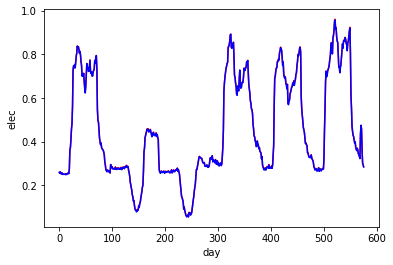

In [13]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})


plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()

# --------------------------------------------------------------------------

# step3 (전력만,optim=RMSPropOptimizer)

In [1]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.set_random_seed(500)

C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4]][1:]
# july_=july.loc[:,[1,2,4]][1:]

In [3]:
jan_

,1,2,4
1,1,1,238.32
2,1,1,236.16
3,1,1,237.24
4,1,1,236.16
5,1,1,234.72
...,...,...,...
2876,1,30,340.2
2877,1,30,294.12
2878,1,30,263.88
2879,1,30,261


In [4]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량']
jan_[['월','일','전력량']]=jan_[['월','일','전력량']].apply(pd.to_numeric)

In [5]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [6]:
#하이퍼 파라미터 설정
timesteps = seq_length = 3  #한개의 시퀀스길이(시계열데이터 입력갯수)
data_dim = 3  #variable개수
hidden_dim = 3  #각셀의 출력크기
output_dim = 1  #결과분류 총 수
learing_rate = 0.001   #학습률
iterations = 50_000   #에폭횟수

In [7]:
# #데이터 조절
# jan_["전력량"] /= 1e5

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량']].values
y = jan_["전력량"].values  

In [8]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [9]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [10]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [11]:
# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

# sum of the squares= 표준편차(예측값과 실제값의차이)
loss = tf.reduce_sum(tf.square(Y_pred - Y))  

In [13]:
#RMSprop 알고리즘: 지수 가중 이동 평균 Exponentially weighted moving average 를 사용하여 최신 기울기들이 더 크게 반영
train = tf.train.RMSPropOptimizer(learing_rate).minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [14]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 196.5313262939453
[step: 100] loss: 121.20664978027344
[step: 150] loss: 118.00421142578125
[step: 200] loss: 104.9573745727539
[step: 250] loss: 68.87947082519531
[step: 300] loss: 32.14753723144531
[step: 350] loss: 20.981460571289062
[step: 400] loss: 14.336662292480469
[step: 450] loss: 11.33072566986084
[step: 500] loss: 10.492339134216309
[step: 550] loss: 10.223517417907715
[step: 600] loss: 10.082488059997559
[step: 650] loss: 9.973913192749023
[step: 700] loss: 9.876992225646973
[step: 750] loss: 9.786798477172852
[step: 800] loss: 9.701591491699219
[step: 850] loss: 9.620323181152344
[step: 900] loss: 9.5421781539917
[step: 950] loss: 9.466500282287598
[step: 1000] loss: 9.392772674560547
[step: 1050] loss: 9.320629119873047
[step: 1100] loss: 9.2498140335083
[step: 1150] loss: 9.180171012878418
[step: 1200] loss: 9.111666679382324
[step: 1250] loss: 9.04430866241455
[step: 1300] loss: 8.978148460388184
[step: 1350] loss: 8.913284301757812
[step: 1400] loss: 

[step: 11000] loss: 0.5920599102973938
[step: 11050] loss: 0.5904041528701782
[step: 11100] loss: 0.588740348815918
[step: 11150] loss: 0.587066113948822
[step: 11200] loss: 0.5853763222694397
[step: 11250] loss: 0.5837041139602661
[step: 11300] loss: 0.5820680856704712
[step: 11350] loss: 0.5804299712181091
[step: 11400] loss: 0.5788232088088989
[step: 11450] loss: 0.5769389271736145
[step: 11500] loss: 0.5762054920196533
[step: 11550] loss: 0.5739495158195496
[step: 11600] loss: 0.5724710822105408
[step: 11650] loss: 0.5712260603904724
[step: 11700] loss: 0.569088339805603
[step: 11750] loss: 0.5682721138000488
[step: 11800] loss: 0.5658791065216064
[step: 11850] loss: 0.5642157196998596
[step: 11900] loss: 0.5632585287094116
[step: 11950] loss: 0.5613360404968262
[step: 12000] loss: 0.5594761371612549
[step: 12050] loss: 0.5577852129936218
[step: 12100] loss: 0.5561836361885071
[step: 12150] loss: 0.5547003746032715
[step: 12200] loss: 0.5531052947044373
[step: 12250] loss: 0.551542

[step: 21450] loss: 0.3850901424884796
[step: 21500] loss: 0.3846123218536377
[step: 21550] loss: 0.384136825799942
[step: 21600] loss: 0.38365861773490906
[step: 21650] loss: 0.383175790309906
[step: 21700] loss: 0.38267290592193604
[step: 21750] loss: 0.38209444284439087
[step: 21800] loss: 0.38165757060050964
[step: 21850] loss: 0.3812050223350525
[step: 21900] loss: 0.38075050711631775
[step: 21950] loss: 0.3803010880947113
[step: 22000] loss: 0.3798518776893616
[step: 22050] loss: 0.37939688563346863
[step: 22100] loss: 0.37895065546035767
[step: 22150] loss: 0.3785051703453064
[step: 22200] loss: 0.3780583143234253
[step: 22250] loss: 0.37761375308036804
[step: 22300] loss: 0.3771687150001526
[step: 22350] loss: 0.3767187297344208
[step: 22400] loss: 0.376277893781662
[step: 22450] loss: 0.3758271336555481
[step: 22500] loss: 0.37538278102874756
[step: 22550] loss: 0.37493789196014404
[step: 22600] loss: 0.37448886036872864
[step: 22650] loss: 0.3740466833114624
[step: 22700] los

[step: 31900] loss: 0.30474475026130676
[step: 31950] loss: 0.3045203685760498
[step: 32000] loss: 0.30459854006767273
[step: 32050] loss: 0.30445194244384766
[step: 32100] loss: 0.30413946509361267
[step: 32150] loss: 0.3038133382797241
[step: 32200] loss: 0.3034723699092865
[step: 32250] loss: 0.303093820810318
[step: 32300] loss: 0.30270057916641235
[step: 32350] loss: 0.3023560345172882
[step: 32400] loss: 0.3020753264427185
[step: 32450] loss: 0.30202245712280273
[step: 32500] loss: 0.3018035888671875
[step: 32550] loss: 0.3013472855091095
[step: 32600] loss: 0.30137205123901367
[step: 32650] loss: 0.300873339176178
[step: 32700] loss: 0.3007507622241974
[step: 32750] loss: 0.30049607157707214
[step: 32800] loss: 0.3002035915851593
[step: 32850] loss: 0.29996612668037415
[step: 32900] loss: 0.29971978068351746
[step: 32950] loss: 0.2994679808616638
[step: 33000] loss: 0.2992223799228668
[step: 33050] loss: 0.29896804690361023
[step: 33100] loss: 0.2987234890460968
[step: 33150] lo

[step: 42300] loss: 0.2584649622440338
[step: 42350] loss: 0.26094329357147217
[step: 42400] loss: 0.2591647207736969
[step: 42450] loss: 0.25773516297340393
[step: 42500] loss: 0.2600615620613098
[step: 42550] loss: 0.2598579227924347
[step: 42600] loss: 0.2568698525428772
[step: 42650] loss: 0.2578006088733673
[step: 42700] loss: 0.25955313444137573
[step: 42750] loss: 0.2594529390335083
[step: 42800] loss: 0.25719717144966125
[step: 42850] loss: 0.25576353073120117
[step: 42900] loss: 0.25675395131111145
[step: 42950] loss: 0.25809434056282043
[step: 43000] loss: 0.25871163606643677
[step: 43050] loss: 0.2585775554180145
[step: 43100] loss: 0.25775346159935
[step: 43150] loss: 0.2565838694572449
[step: 43200] loss: 0.25545307993888855
[step: 43250] loss: 0.25460395216941833
[step: 43300] loss: 0.25414371490478516
[step: 43350] loss: 0.2540593445301056
[step: 43400] loss: 0.25428301095962524
[step: 43450] loss: 0.25473418831825256
[step: 43500] loss: 0.25529050827026367
[step: 43550]

In [15]:
a=0
length=len(dataY)
for k in range(0,length-1):
    a+=dataY[k][0]
real_avg=a/length

test_predict = sess.run(Y_pred, feed_dict={X: testX}) #예측값
length_=len(test_predict)

b=0
for j in range(0,length_-1):
    b+=test_predict[j][0]
pred_avg=b/length_
    
#(절대값(실제값의 평균 - 예측값의 평균)/실제값의 평균) *100 =평균 오차율 산정 방식
accuracy=(abs(real_avg-pred_avg)/real_avg)*100
print(accuracy)

2.7302831276270303


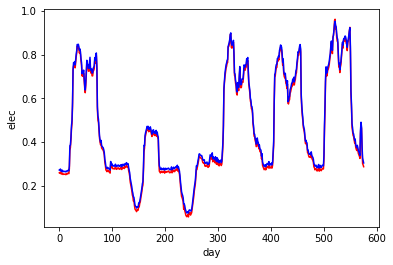

In [16]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})

plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()

In [18]:
test_predict

array([[0.2713458 ],
       [0.27026406],
       [0.27594167],
       [0.2679586 ],
       [0.26539028],
       [0.2715481 ],
       [0.26637578],
       [0.26330405],
       [0.2661841 ],
       [0.26548666],
       [0.26436377],
       [0.2652558 ],
       [0.263143  ],
       [0.26581755],
       [0.26405776],
       [0.26716524],
       [0.26776904],
       [0.27095568],
       [0.26768988],
       [0.28909367],
       [0.382987  ],
       [0.38561165],
       [0.41932115],
       [0.47380987],
       [0.49781114],
       [0.57950103],
       [0.7307552 ],
       [0.7629676 ],
       [0.7548609 ],
       [0.7675667 ],
       [0.75220597],
       [0.7799895 ],
       [0.8028579 ],
       [0.81974864],
       [0.84625053],
       [0.8401332 ],
       [0.8469238 ],
       [0.8360543 ],
       [0.8194654 ],
       [0.82581484],
       [0.812163  ],
       [0.7813771 ],
       [0.7631488 ],
       [0.71227443],
       [0.7230067 ],
       [0.71327627],
       [0.7284945 ],
       [0.690

# -----------------------------------------------------------

# step4(전력,온도,optim=RMSPropOptimizer)

In [1]:
#http://mjgim.me/2017/08/02/LSTM.html

#라이브러리 불러오기
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.set_random_seed(500)

C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
#데이터 불러오기
jan = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/1월.csv", header=None)
july = pd.read_csv(r"C:/Users/jmlee/Desktop/4학년 2학기/딥러닝 전력 예측/전력 예측/생성data/7월.csv", header=None)
jan_=jan.loc[:,[1,2,4,6]][1:]
# july_=july.loc[:,[1,2,4]][1:]

In [3]:
# All=pd.concat([jan_,july_])
#str을 float로 바꾸기
jan_.columns=['월','일','전력량','온도']
jan_[['월','일','전력량','온도']]=jan_[['월','일','전력량','온도']].apply(pd.to_numeric)

In [4]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [5]:
#하이퍼 파라미터 설정
timesteps = seq_length = 3  #한개의 시퀀스길이(시계열데이터 입력갯수)
data_dim = 4  #variable개수
hidden_dim = 3  #각셀의 출력크기
output_dim = 1  #결과분류 총 수
learing_rate = 0.001   #학습률
iterations = 50_000   #에폭횟수

In [6]:
# #데이터 조절
# jan_["전력량"] /= 1e5

#Framework 제작
jan_['전력량']=MinMaxScaler(jan_['전력량'])
x = jan_[['월','일','전력량','온도']].values
y = jan_["전력량"].values  

In [7]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):  #seq_length=timesteps=
    _x = np.copy(x[i:i + seq_length + 1])
#     _x[timesteps-2][data_dim-1] = 0
#     _x[timesteps-1][data_dim-1] = 0
#     _x[timesteps][data_dim-1] = 0
    _y = [y[i + seq_length]] #다음 전력(정답)
    dataX.append(_x)
    dataY.append(_y)

In [8]:
#학습데이터와 테스트데이터 분류

train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size 

trainX = np.array(dataX[:train_size])  #2298
testX = np.array(dataX[train_size : ])

trainY = np.array(dataY[:train_size])  #575
testY = np.array(dataY[train_size : ])

In [9]:
#LSTM모델 구축
#placeholder 초기화 후 텐서에 매핑
X = tf.placeholder(tf.float32, [None, seq_length+1, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

def lstm_cell(): #cell생성
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim, reuse=tf.AUTO_REUSE)  #출력의 크기를 hidden dim=4
    return cell 
## 5 layers for hidden layer
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(5)], state_is_tuple=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [10]:
# dynamic rnn 구조(RNN 신경망)연결
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32) #결과값 output차원은 hidden_dim의 크기와 동일

Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)

# sum of the squares= 표준편차(예측값과 실제값의차이)
loss = tf.reduce_sum(tf.square(Y_pred - Y))  

#RMSprop 알고리즘
train = tf.train.RMSPropOptimizer(learing_rate).minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
for i in range(iterations):
    _  , cost = sess.run([train ,loss], feed_dict={X: trainX, Y: trainY})
    if (i+1) % (iterations/1000) == 0:
        print("[step: {}] loss: {}".format(i+1, cost))

[step: 50] loss: 197.8739471435547
[step: 100] loss: 122.07440948486328
[step: 150] loss: 120.85841369628906
[step: 200] loss: 116.11582946777344
[step: 250] loss: 99.98678588867188
[step: 300] loss: 71.45633697509766
[step: 350] loss: 34.411285400390625
[step: 400] loss: 15.867313385009766
[step: 450] loss: 12.30759334564209
[step: 500] loss: 11.361457824707031
[step: 550] loss: 10.916762351989746
[step: 600] loss: 10.656579971313477
[step: 650] loss: 10.480658531188965
[step: 700] loss: 10.348348617553711
[step: 750] loss: 10.2410888671875
[step: 800] loss: 10.149553298950195
[step: 850] loss: 10.068568229675293
[step: 900] loss: 9.995216369628906
[step: 950] loss: 9.927572250366211
[step: 1000] loss: 9.864360809326172
[step: 1050] loss: 9.804794311523438
[step: 1100] loss: 9.748198509216309
[step: 1150] loss: 9.694138526916504
[step: 1200] loss: 9.642239570617676
[step: 1250] loss: 9.592236518859863
[step: 1300] loss: 9.543938636779785
[step: 1350] loss: 9.497119903564453
[step: 140

[step: 11100] loss: 1.1543830633163452
[step: 11150] loss: 1.1443060636520386
[step: 11200] loss: 1.1345041990280151
[step: 11250] loss: 1.1249492168426514
[step: 11300] loss: 1.115607500076294
[step: 11350] loss: 1.1066359281539917
[step: 11400] loss: 1.0976556539535522
[step: 11450] loss: 1.0888556241989136
[step: 11500] loss: 1.079833984375
[step: 11550] loss: 1.0720067024230957
[step: 11600] loss: 1.0638456344604492
[step: 11650] loss: 1.0557585954666138
[step: 11700] loss: 1.0477505922317505
[step: 11750] loss: 1.039791464805603
[step: 11800] loss: 1.0319302082061768
[step: 11850] loss: 1.024169921875
[step: 11900] loss: 1.0165358781814575
[step: 11950] loss: 1.0090006589889526
[step: 12000] loss: 1.0016106367111206
[step: 12050] loss: 0.9943075776100159
[step: 12100] loss: 0.9870638847351074
[step: 12150] loss: 0.9799042344093323
[step: 12200] loss: 0.9726874828338623
[step: 12250] loss: 0.9655656218528748
[step: 12300] loss: 0.9587134122848511
[step: 12350] loss: 0.9521154165267

[step: 21650] loss: 0.5478572249412537
[step: 21700] loss: 0.5475229620933533
[step: 21750] loss: 0.5462732911109924
[step: 21800] loss: 0.5451908111572266
[step: 21850] loss: 0.543921709060669
[step: 21900] loss: 0.5435492396354675
[step: 21950] loss: 0.5427396297454834
[step: 22000] loss: 0.5422476530075073
[step: 22050] loss: 0.5409959554672241
[step: 22100] loss: 0.5401768088340759
[step: 22150] loss: 0.5386452674865723
[step: 22200] loss: 0.5381909012794495
[step: 22250] loss: 0.5366259217262268
[step: 22300] loss: 0.5364478230476379
[step: 22350] loss: 0.5350139737129211
[step: 22400] loss: 0.5346460938453674
[step: 22450] loss: 0.5331635475158691
[step: 22500] loss: 0.532777726650238
[step: 22550] loss: 0.531428337097168
[step: 22600] loss: 0.5310402512550354
[step: 22650] loss: 0.5297170281410217
[step: 22700] loss: 0.5297018885612488
[step: 22750] loss: 0.5288935899734497
[step: 22800] loss: 0.5275198817253113
[step: 22850] loss: 0.5269194841384888
[step: 22900] loss: 0.526082

[step: 32100] loss: 0.399453729391098
[step: 32150] loss: 0.3998451232910156
[step: 32200] loss: 0.39838171005249023
[step: 32250] loss: 0.3987351655960083
[step: 32300] loss: 0.397304505109787
[step: 32350] loss: 0.39764341711997986
[step: 32400] loss: 0.396229088306427
[step: 32450] loss: 0.3965466618537903
[step: 32500] loss: 0.39516177773475647
[step: 32550] loss: 0.39546456933021545
[step: 32600] loss: 0.3941028118133545
[step: 32650] loss: 0.3943737745285034
[step: 32700] loss: 0.39302879571914673
[step: 32750] loss: 0.3932865858078003
[step: 32800] loss: 0.3919646143913269
[step: 32850] loss: 0.39220160245895386
[step: 32900] loss: 0.3908972144126892
[step: 32950] loss: 0.3911162316799164
[step: 33000] loss: 0.38983169198036194
[step: 33050] loss: 0.39002543687820435
[step: 33100] loss: 0.38876426219940186
[step: 33150] loss: 0.38894444704055786
[step: 33200] loss: 0.3876877427101135
[step: 33250] loss: 0.38785359263420105
[step: 33300] loss: 0.3866199851036072
[step: 33350] los

[step: 42500] loss: 0.29851096868515015
[step: 42550] loss: 0.2968641221523285
[step: 42600] loss: 0.29543831944465637
[step: 42650] loss: 0.2977413833141327
[step: 42700] loss: 0.29608842730522156
[step: 42750] loss: 0.293064147233963
[step: 42800] loss: 0.295206755399704
[step: 42850] loss: 0.29626724123954773
[step: 42900] loss: 0.29486843943595886
[step: 42950] loss: 0.2911500632762909
[step: 43000] loss: 0.2919345498085022
[step: 43050] loss: 0.2936093807220459
[step: 43100] loss: 0.29430827498435974
[step: 43150] loss: 0.2936849892139435
[step: 43200] loss: 0.290850430727005
[step: 43250] loss: 0.28826332092285156
[step: 43300] loss: 0.28873589634895325
[step: 43350] loss: 0.2904253602027893
[step: 43400] loss: 0.29171040654182434
[step: 43450] loss: 0.2917352616786957
[step: 43500] loss: 0.2894737124443054
[step: 43550] loss: 0.2861824333667755
[step: 43600] loss: 0.28551602363586426
[step: 43650] loss: 0.28631237149238586
[step: 43700] loss: 0.28696203231811523
[step: 43750] lo

In [12]:
a=0
length=len(dataY)
for k in range(0,length-1):
    a+=dataY[k][0]
real_avg=a/length

test_predict = sess.run(Y_pred, feed_dict={X: testX}) #예측값
length_=len(test_predict)

b=0
for j in range(0,length_-1):
    b+=test_predict[j][0]
pred_avg=b/length_
    
#(절대값(실제값의 평균 - 예측값의 평균)/실제값의 평균) *100 =평균 오차율 산정 방식
accuracy=(abs(real_avg-pred_avg)/real_avg)*100
print(accuracy)

3.336667390952787


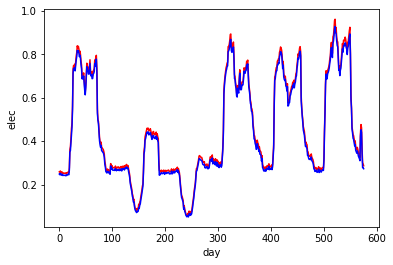

In [13]:
#예측값 불러오기
train_predict = sess.run(Y_pred, feed_dict={X: trainX})
test_predict = sess.run(Y_pred, feed_dict={X: testX})

plt.plot(testY,'r')
plt.plot(test_predict,'b')
plt.xlabel("day")
plt.ylabel("elec")
plt.show()